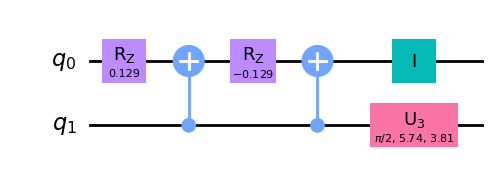

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


In [4]:
from qiskit.primitives import Estimator
estimator = Estimator()

In [5]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: e580ee90-f7f1-4096-99f6-94cd8e914ae6
>>> Job Status: JobStatus.DONE


In [6]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")

>>> EstimatorResult(values=array([0.85347811]), metadata=[{}])
  > Expectation value: 0.8534781134132173


### 对于Hamiltonian 的期望值测量问题

In [9]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
import warnings
from qiskit_nature.circuit.library import HartreeFock,UCCSD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE

from qiskit_nature.settings import QiskitNatureSettings
QiskitNatureSettings.dict_aux_operators = True

import numpy as np 
warnings.filterwarnings("ignore")

/tmp/ipykernel_22687/115704485.py:15: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
/tmp/ipykernel_22687/115704485.py:15: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory


In [30]:
molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

#driver = PySCFDriver(atom="O 0 0 0;H 0.758602 0 0.504284;H 0.758602 0 -0.504284",basis="sto-3g")

problem = driver.run()
converter = QubitConverter(JordanWignerMapper())
PN_property = problem.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)

problem = ElectronicStructureProblem(driver, [transformer])
second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print('轨道数目：{a}\n粒子数目{b}\n'.format(a=num_spin_orbitals,b=num_particles))
ansatz= UCCSD(num_particles=num_particles,num_spin_orbitals=num_spin_orbitals,qubit_converter=converter,initial_state=init_state)

ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
轨道数目：4
粒子数目(1, 1)



### 真实ansatz电路的测量

'decompose前'

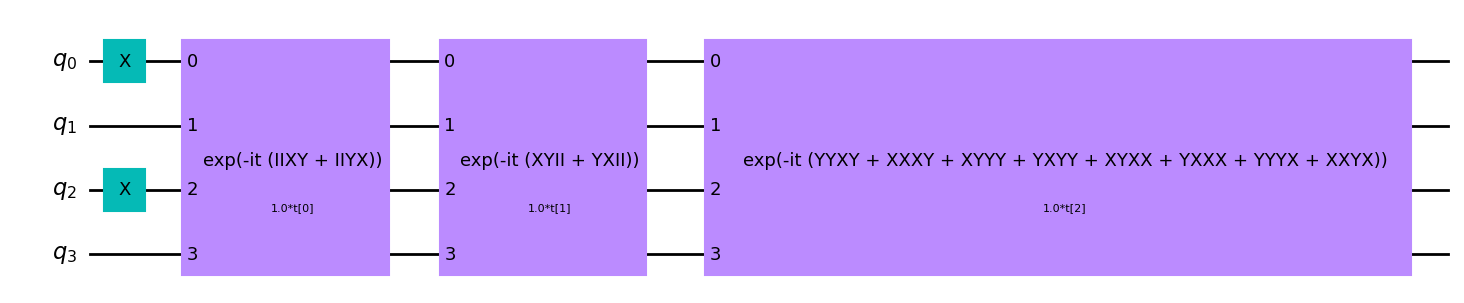

In [39]:
display('decompose前',ansatz.decompose().draw('mpl'))
a = ansatz.decompose()
#display('decompose后',ansatz.decompose().decompose().draw('mpl'))

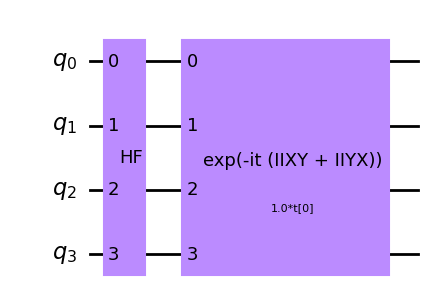

In [109]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(4)
qc.append(init_state.to_instruction(),[0,1,2,3])
qc.append(a[2],[0,1,2,3])
display(qc.draw('mpl'))

In [61]:
qubit_op = problem.second_q_ops()['ElectronicEnergy']
Hamiltonian  = converter.convert(qubit_op)
display('哈密顿量由{0}项组成'.format(len(Hamiltonian)),Hamiltonian)

'哈密顿量由15项组成'

PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.87206336+0.j,  0.11923749+0.j, -0.17865262+0.j,  0.11923749+0.j,
 -0.17865262+0.j,  0.14753433+0.j,  0.22003977+0.j,  0.00963433+0.j,
  0.00963433+0.j,  0.00963433+0.j,  0.00963433+0.j,  0.15716866+0.j,
  0.15716866+0.j,  0.16144783+0.j,  0.14753433+0.j]), coeff=1.0)

#### 以上操作已经制备好了Hamiltonian量（15项）和需要测量的电路  接下来开始使用Estimator测量

In [78]:
Hamiltonian[3]
A = SparsePauliOp("IZII")

In [110]:
qc = qc.bind_parameters([0.2])
display('观测算符是{0}被观测的电路是'.format(Hamiltonian[3]),qc.decompose().draw())
job = estimator.run(qc,Hamiltonian[3])


'观测算符是0.11923749314031587 * IZII被观测的电路是'

┌───┐┌───────────────┐┌───────────────┐
q_0: ┤ X ├┤0              ├┤0              ├
     └───┘│               ││               │
q_1: ─────┤1              ├┤1              ├
     ┌───┐│  exp(it IIXY) ││  exp(it IIYX) │
q_2: ┤ X ├┤2              ├┤2              ├
     └───┘│               ││               │
q_3: ─────┤3              ├┤3              ├
          └───────────────┘└───────────────┘

In [111]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")

>>> EstimatorResult(values=array([-0.11923749]), metadata=[{}])
  > Expectation value: -0.11923749314031576


In [112]:
result

EstimatorResult(values=array([-0.11923749]), metadata=[{}])

In [101]:
qc.bind_parameters([0.2,0.2])
qc.decompose().decompose().draw('mpl')

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.